# Multi-Label Classification


source:  [github / muellerzr /
Practical-Deep-Learning-for-Coders-2.0](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/04_Multi_Label.ipynb)

Today we will be going over **multi-label** classification

First let's install our libraries

In [1]:
# Run once per session
# import os
# !pip install -q feather-format kornia pyarrow wandb nbdev fastprogress fastai2 fastcore --upgrade 
!pip show torch
# !pip install torch==1.3.1
!pip show torchvision
# !pip install torchvision==0.4.2
!pip show Pillow
# !pip install Pillow==6.2.1 --upgrade
# os._exit(00)

Name: torch
Version: 1.3.1
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /home/ubuntu/anaconda3/envs/fastai2/lib/python3.7/site-packages
Requires: numpy
Required-by: torchvision, kornia, fastai2
Name: torchvision
Version: 0.4.2
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /home/ubuntu/anaconda3/envs/fastai2/lib/python3.7/site-packages
Requires: pillow, numpy, six, torch
Required-by: fastai2
Name: Pillow
Version: 6.2.1
Summary: Python Imaging Library (Fork)
Home-page: http://python-pillow.org
Author: Alex Clark (PIL Fork Author)
Author-email: aclark@python-pillow.org
License: HPND
Location: /home/ubuntu/anaconda3/envs/fastai2/lib/python3.7/site-packages
Requires: 
Required-by: torchvision,

Now let's grab what we need. For this particular one, we want `vision` and `data`

In [2]:
import fastai2
from fastai2.data.all import *
from fastai2.vision.all import *
from fastai2.callback.all import *

In [3]:
fastai2.__version__

'0.0.11'

In [4]:
!pip show fastai2

Name: fastai2
Version: 0.0.10
Summary: Version 2 of the fastai library
Home-page: https://github.com/fastai/fastai2
Author: Jeremy Howard, Sylvain Gugger, and contributors
Author-email: info@fast.ai
License: Apache Software License 2.0
Location: /home/ubuntu/anaconda3/envs/fastai2/lib/python3.7/site-packages
Requires: scikit-learn, fastprogress, spacy, torch, pandas, scipy, pillow, pyyaml, matplotlib, torchvision, requests, fastcore
Required-by: 


For this multi-label problem, we will use the Planet dataset, where it's a collection of satellite images with multiple labels describing the scene. I'll go through and explain a few different ways to make this dataset, highlighting some of the flexibility the new `DataBlock` API can do. 

First, let's grab our data

In [5]:
planet_source = untar_data(url=URLs.PLANET_SAMPLE, dest='/home/ubuntu/datasets/')
df = pd.read_csv(planet_source/'labels.csv')

Now let's look at how it's stored. Our `DataFrame` is formatted so our images filename is the **first** column, and the labels in the **second**

In [6]:
df.head()

,image_name,tags
0,train_21983,partly_cloudy primary
1,train_9516,clear cultivation primary water
2,train_12664,haze primary
3,train_36960,clear primary
4,train_5302,haze primary road


# Method 1 (DataBlock)

In [7]:
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [8]:
planet = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, pref=f'{planet_source}/train/', suff='.jpg'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   batch_tfms = batch_tfms)

In [9]:
f'{planet_source}/train/'

'/home/ubuntu/datasets/planet_sample/train/'

In [10]:
!ls '{planet_source}/train/' | head -5

train_10001.jpg
train_10007.jpg
train_10030.jpg
train_10033.jpg
train_10042.jpg
ls: write error: Broken pipe


* Multi-label so we want a `MultiCategoryBlock`
* `get_x` and `get_y` define how we expect to grab our data
* `ColReader` works with Pandas `DataFrames`

Now we can dataloaders by passing in our source folder

In [11]:
dls = planet.dataloaders(df)

KeyError: 'c'

In [12]:
dls.show_batch(max_n=9, figsize=(12,9))

NameError: name 'dls' is not defined

# Method 2: `Lambda`'s

This next version will instead use `lambda` functions to grab our image names, which get's rid of the `ColReader`, if you're more familiar with these

In [13]:
blocks = (ImageBlock, MultiCategoryBlock)

First let's try our `get_x`. Our lambda function needs to return a `Path()` to our particular image. This can be done by including `f'{x[0]}.jpg'` 

But what is that even doing? Let's take a look

In [14]:
get_x = lambda x:planet_source/'train'/f'{x[0]}.jpg'

If we pass in one row of our `DataFrame`, we should expect to see the entire path laid out in front of us!

In [15]:
val = df.values[0]; val

array(['train_21983', 'partly_cloudy primary'], dtype=object)

In [16]:
get_x(df.values[0])

Path('/home/ubuntu/datasets/planet_sample/train/train_21983.jpg')

Which it does! A nice, simple, and *clean* way to grab our paths. Let's see how our `y` getter will look like

In [17]:
get_y = lambda x:x[1].split(' ')

In [18]:
get_y(df.values[1])

['clear', 'cultivation', 'primary', 'water']

In [19]:
get_y(df.values[2])

['haze', 'primary']

In [20]:
get_y(df.values[3])

['clear', 'primary']

Looks fairly close to the previous version, if you pay attention. Remember that our `x` is the `DataFrame`'s values, so if we grab position 1 from earlier, we can see that it's our labels!

Let's make our full `PipeLine` now that we're sure everything will work

In [21]:
planet = DataBlock(blocks=blocks,
                   get_x=get_x,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   batch_tfms=batch_tfms)

In [22]:
dls = planet.dataloaders(df, bs=8)
dls.show_batch(max_n=9, figsize=(12,9))

KeyError: 'c'

# Method 3: Custom `get_items` Functions

That previous one worked fine, but shouldn't I be able to do a one-liner? Since it's all right there instead of defining our `get_x` and `get_y`? There *IS*! We can create our own function, where we should expect to return both an `x` and a `y` value. Let's make one 

In [23]:
def _planet_items(x): return (
    f'{planet_source}/train/'+x.image_name+'.jpg', x.tags.str.split())

Our `DataBlock` now looks like so:

In [24]:
planet = DataBlock.from_columns(blocks=(ImageBlock, MultiCategoryBlock),
                   get_items = _planet_items, 
                   splitter=RandomSplitter(),
                   batch_tfms=batch_tfms)

That's all our `DataBlock` needs if we can plan accordingly. Looks pretty clean!

In [25]:
dls = planet.dataloaders(df)
dls.show_batch(max_n=9, figsize=(12,9))

KeyError: 'p'

# Training a Model

We'll use a `resnet34` for this task

In [0]:
from torchvision.models import resnet34

We'll use `accuracy_multi` for multi-classificaiton

In [0]:
from fastai2.metrics import accuracy_multi

In [0]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=[accuracy_multi])

Model results are on a scale with a threshold instead of exact, allows for "it's not any" due to a sigmoid activation in the loss function

In [0]:
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

In [0]:
learn.loss_func = BCEWithLogitsLossFlat()

We'll find a good learning rate

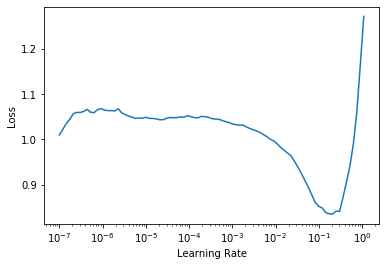

In [0]:
learn.lr_find()

And train! (we'll also used mixed precision too!)

In [0]:
lr = 1e-2
learn = learn.to_fp16()

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.761724,0.320393,0.894412,00:14
1,0.366634,0.170998,0.940882,00:11
2,0.256233,0.149577,0.949118,00:11
3,0.199033,0.137296,0.949706,00:11
4,0.170974,0.136933,0.949706,00:11


Great! Let's save and `unfreeze` to train the rest of our model!

In [0]:
learn.save('stage-1')

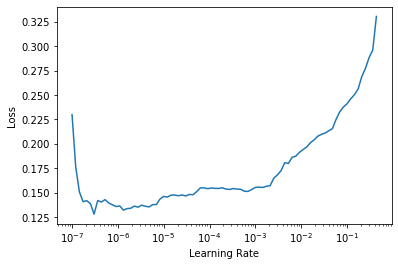

In [0]:
learn.unfreeze()
learn.lr_find()

We can now go through and use a learning rate around 1e-5 or so, and then have an ending learning rate five times smaller than our starting

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.147181,0.146752,0.947353,00:15
1,0.153571,0.138148,0.953530,00:15
2,0.147831,0.129908,0.953530,00:15
3,0.127491,0.124736,0.956765,00:15
4,0.114531,0.126795,0.954118,00:15


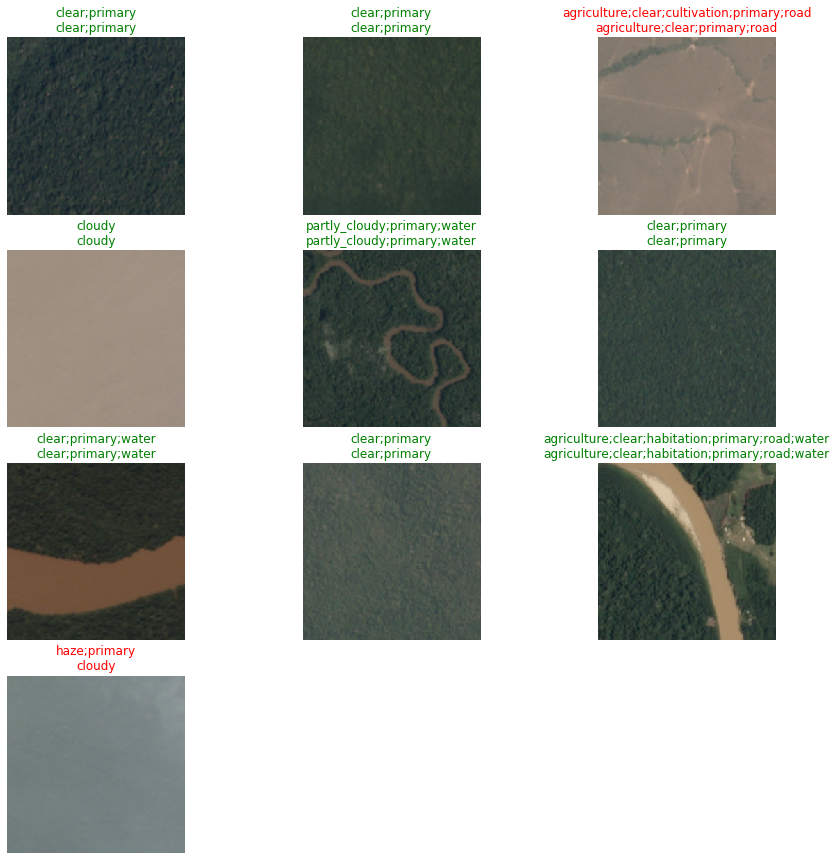

In [0]:
learn.show_results(figsize=(15,15))